# Importing what we'll need to train the model

In [1]:
import torch

import torch.nn as nn #Will be using nn, functional, and optim so importing it separately
import torch.nn.functional as F
import torch.optim as optim

import torchvision #Using torchvision to load the MNIST data
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader

import sklearn

!pip install wandb
import wandb

from PIL import Image

import matplotlib.pyplot as plt

In [2]:
#Config stuff

train_ratio = 0.8
test_ratio = 1 - train_ratio

batch_size_train = 32
batch_size_test = 128
epochs = 4

learning_rate = 0.01
momentum = 0.5


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random_seed = 1 #Fixing this seed as well for reproducability
generator1 = torch.Generator().manual_seed(42) #Fixed seed for reproducability

In [3]:
train_data_full = torchvision.datasets.MNIST('root', train = True,download = True, transform=torchvision.transforms.Compose([ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))]))
test_data = torchvision.datasets.MNIST('root', train = False, transform=torchvision.transforms.Compose([ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

print(f"The train data has {len(train_data_full)} rows") #Checking that it loaded correctly.
print(f"the test data has {len(test_data)} rows")

The train data has 60000 rows
the test data has 10000 rows


In [4]:
train_data, val_data = torch.utils.data.random_split(train_data_full, [train_ratio, test_ratio], generator=generator1)

print(f"The train data has {len(train_data)} rows") #Checking that it split correctly.
print(f"The val data has {len(val_data)} rows")
print(f"the test data has {len(test_data)} rows")

The train data has 48001 rows
The val data has 11999 rows
the test data has 10000 rows


(array([1188., 1359., 1195., 1245., 1161., 1053., 1166., 1282., 1177.,
        1173.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

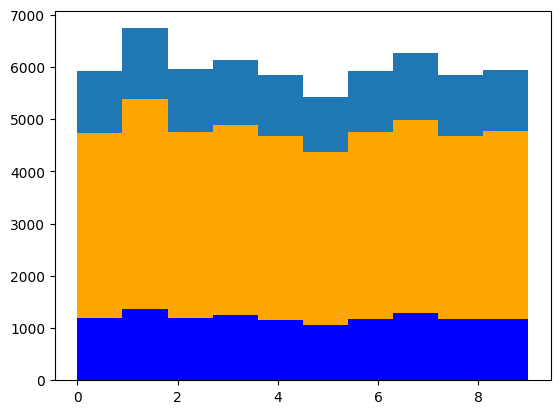

In [5]:
#Checking if the distributions are similar between the original set, training set, and validation set.
plt.hist([y for _,y in train_data_full])
plt.hist([y for _,y in train_data], color = "Orange")
plt.hist([y for _,y in val_data], color = "Blue")

In [6]:
train_loader = DataLoader(train_data, batch_size_train, shuffle = True)
val_loader = DataLoader(val_data, batch_size_test, shuffle = False)
test_loader = DataLoader(test_data, batch_size_test, shuffle = False)

In [7]:
x,y = next(iter(train_loader))
print(x.shape) #Our images are shape 1x28x28 because there's only 1 color channel and 28x28 pixels so we have tensors of shape [batch_size, 1, 28, 28]
print(y.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32])


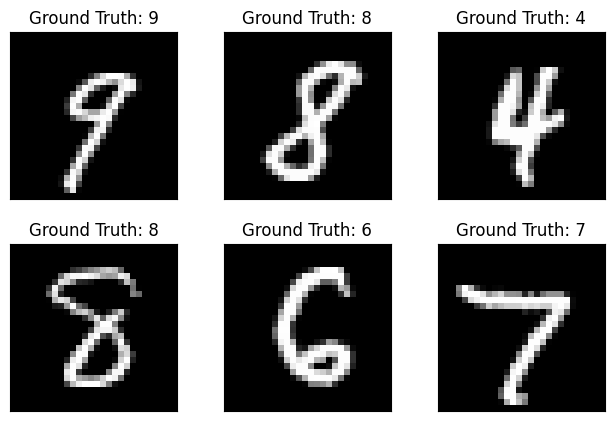

In [8]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(x[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(y[i]))
  plt.xticks([])
  plt.yticks([])

# Defining the CNN we'll be using

Following this guide: https://nextjournal.com/gkoehler/pytorch-mnist by Gregor Koehler

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
#We use a convolution layer because it performs a convolution on the image and the kernel (the matrix with learnable parameters). This process theoretically should result in
#kernels that can identify features such as edges.

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) #Our images are in greyscale so our input channels is 1 (3 if RGB).
#Our output channel size is now 10 because we want to train 10 kernels (ie learn to identify 10 "features" and embed info into kernel). The shape of the image goes from 28x28 to 24x24
#In between conv1 and conv2 we will apply max_pool2d which will go over the data with a window and stride of 2, reducing the image from 24x24 to 12x12. Same channel size (10) though.
#We also apply a relu activation function after the max_pool2d
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) #Our channel size out is 20 now and uses our features from conv1 to identify 20 more features. We then go from 12x12 to 8x8
        self.conv2_drop = nn.Dropout2d() #We apply a dropout layer after the convolution
        #We apply another max_pool2d and relu after which reduces our image sizes to 4x4. So our image is of the shape: 20 x 4 x 4 = 320
#We then reshape our 32x20x4x4 tensor (batch_size, channels, height, width) into a 1x320 one (batch_size, parameters) before passing it into the linear layer
        self.fc1 = nn.Linear(320, 50) #Passing our 32x320 tensor into the linear layer. Giving us a smaller 32x50 tensor. Afterwards we apply relu activation.
#We apply a dropout layer between the linear layers
        self.fc2 = nn.Linear(50, 10) #We apply one more linear layer and go from 32x50 to 32x10 tensor.
#Finally we apply a log_softmax to our 32x10 tensors to turn our 32x10 tensor from unbounded numbers between [-inf, inf] into log-probabilities between [-inf, 0]
#Taking their exponents would make it between [0, 1] and the same as softmax but log_softmax calculations are quicker and more stable so they are preferred and interpeted the same.
#It is possible that softmax might give better results as the gradients are not the same but as mentioned is less stable and slower.

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim = 1)

In [10]:
model = Net()

model.to(device) #Moving the model to the GPU if available. Otherwise CPU. Will need to move the data to device during the loop.

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

train_epoch_losses = []
train_batch_losses = []

val_epoch_loss = []
val_cor_count = []

test_batch_losses = []
test_epoch_losses = []
test_cor_count = []

In [11]:
def train():
  for epoch in range(epochs):
    ep_loss = 0
    model.train()
    for batch_ind, (X, y) in enumerate(train_loader):
      #Clearing the gradients back to 0
      optimizer.zero_grad()

      #Making predictions with our model
      out = model(X)

      #Calculating the loss
      loss = F.nll_loss(out, y)

      #Calculating the gradients
      loss.backward()

      #Updating the weights via the optimizer
      optimizer.step()

      #Storing the average loss for that batch and updating the epoch loss
      train_batch_losses.append(loss.item())
      ep_loss += loss.item()

      if batch_ind%200 == 0:
        print(f'Epoch {epoch+1} | Batch {batch_ind} loss: {train_batch_losses[len(train_batch_losses)-1]:.5f}')

    #Storing the average loss for the epoch
    train_epoch_losses.append(ep_loss)

    #Computing the losses on the validation set to verify performance
    val()
    print(f'\nFinal batch loss for Epoch {epoch+1}: {train_batch_losses[len(train_batch_losses)-1]:.5f}')
    print(f'Val loss for Epoch {epoch+1}: {val_epoch_loss[len(val_epoch_loss)-1]:.5f} | Correct count: {val_cor_count[len(val_cor_count)-1]} | As percent: {100*val_cor_count[len(val_cor_count)-1]/len(val_loader.dataset):.2f}%\n')

def val():
  model.eval()
  ep_loss = 0
  correct_cnt = 0
  with torch.no_grad():
    for X,y in val_loader:
      out = model(X)
      _,pred = torch.max(out, dim = 1)
      loss = F.nll_loss(out,y, reduction = 'sum')
      correct_cnt += torch.sum(pred == y).item()

      ep_loss += loss.item()

  val_epoch_loss.append(ep_loss/len(val_loader.dataset))
  val_cor_count.append(correct_cnt)

def test():
  model.eval()
  ep_loss = 0
  correct_cnt = 0
  with torch.no_grad():
    for X,y in val_loader:
      out = model(X)
      _,pred = torch.max(out, dim = 1)
      loss = F.nll_loss(out,y)
      correct_cnt += torch.sum(pred == y).item()

  test_cor_count.append(correct_cnt)

In [12]:
val()
print(f'Val loss before: {val_epoch_loss[len(val_epoch_loss)-1]:.5f} | Correct count: {val_cor_count[len(val_cor_count)-1]} | As percent: {100*val_cor_count[len(val_cor_count)-1]/len(val_loader.dataset):.2f}%\n')
train()

Val loss before: 2.31427 | Correct count: 745 | As percent: 6.21%

Epoch 1 | Batch 0 loss: 2.29493
Epoch 1 | Batch 200 loss: 1.30521
Epoch 1 | Batch 400 loss: 0.78917
Epoch 1 | Batch 600 loss: 0.36674
Epoch 1 | Batch 800 loss: 0.54096
Epoch 1 | Batch 1000 loss: 0.50539
Epoch 1 | Batch 1200 loss: 0.42780
Epoch 1 | Batch 1400 loss: 0.23491

Final batch loss for Epoch 1: 0.00013
Val loss for Epoch 1: 0.15836 | Correct count: 11450 | As percent: 95.42%

Epoch 2 | Batch 0 loss: 0.27275
Epoch 2 | Batch 200 loss: 0.22030
Epoch 2 | Batch 400 loss: 0.22861
Epoch 2 | Batch 600 loss: 0.06522
Epoch 2 | Batch 800 loss: 0.53376
Epoch 2 | Batch 1000 loss: 0.15527
Epoch 2 | Batch 1200 loss: 0.17574
Epoch 2 | Batch 1400 loss: 0.41263

Final batch loss for Epoch 2: 0.00709
Val loss for Epoch 2: 0.10872 | Correct count: 11603 | As percent: 96.70%

Epoch 3 | Batch 0 loss: 0.27539
Epoch 3 | Batch 200 loss: 0.27076
Epoch 3 | Batch 400 loss: 0.09209
Epoch 3 | Batch 600 loss: 0.37963
Epoch 3 | Batch 800 loss:

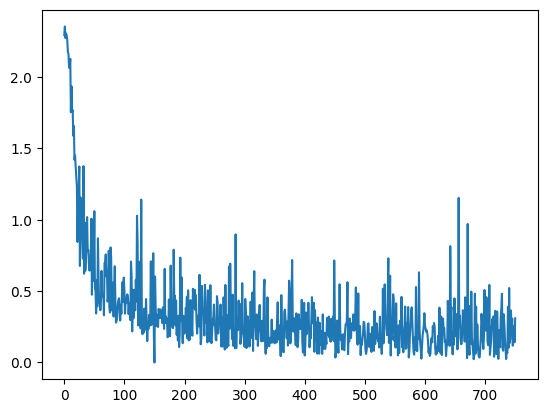

In [13]:
plt.plot(train_batch_losses[0:len(train_batch_losses):10], )

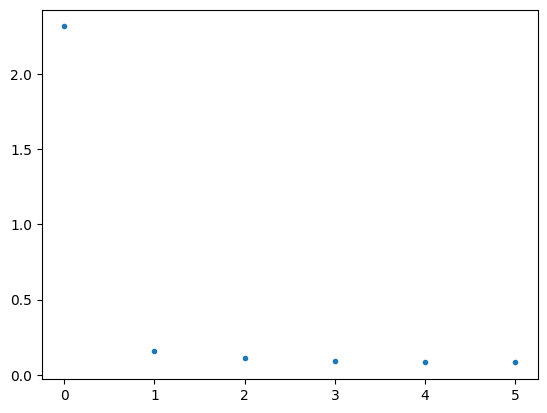

In [14]:
plt.plot(val_epoch_loss, '.')

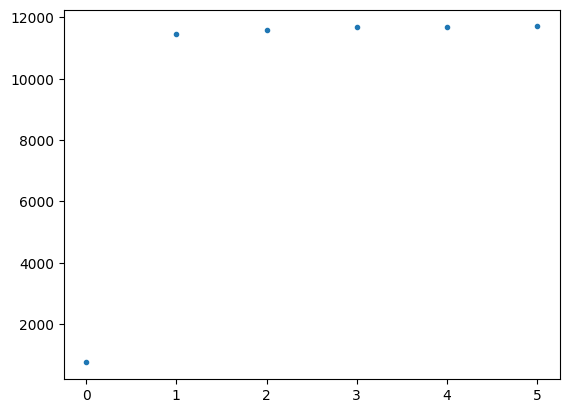

In [15]:
plt.plot(val_cor_count, '.')

In [16]:
example_data = next(iter(train_loader))
with torch.no_grad():
  output = model(example_data[0])

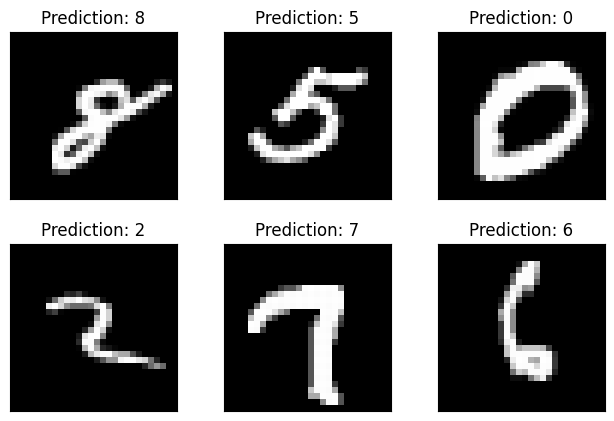

In [17]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[0][i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

In [18]:
test()

In [22]:
test_cor_count

[11707]

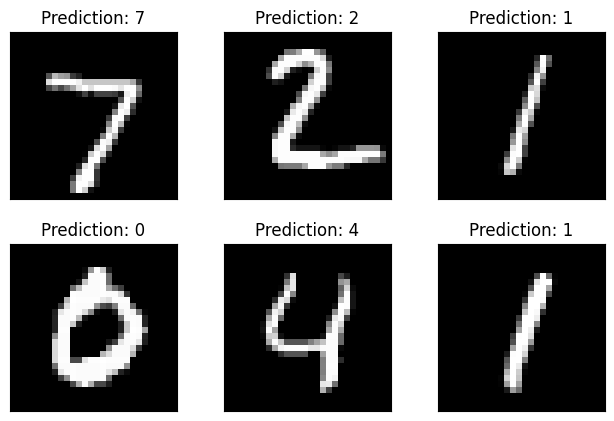

In [20]:
example_data = next(iter(test_loader))
with torch.no_grad():
  output = model(example_data[0])

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[0][i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])